In [12]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn.init
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.functional import batch_norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import os

In [13]:
!pip install wandb
import wandb

In [14]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


In [15]:
entity_name="team_zulkar"

project_name="CS6910_Assignment_2A"

## **Data Preparation**

In [16]:
def unaug_data():
    data = '/kaggle/input/inaturalist-dataset/inaturalist_12K'

    ## Unaugmented data


    data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    #train dataset
    train_dataset = datasets.ImageFolder(root=f"{data}/train", transform=data_transforms)
    #test dataset
    test_dataset = datasets.ImageFolder(root=f"{data}/val", transform=data_transforms)

    initial_size = len(train_dataset)
    train_size = int(0.8 * initial_size)
    val_size = initial_size - train_size

    # Spliting the train dataset into train and validation data
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Loading the dataset
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

    return  train_loader, test_loader, val_loader

In [17]:
def aug_data():
    data = '/kaggle/input/inaturalist-dataset/inaturalist_12K'

    ## augmented data


    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
              transforms.RandomVerticalFlip(p=0.5),
              transforms.RandomRotation((120)),
              transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.5),
              transforms.Resize((224,224)),
              transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


    #train dataset
    train_dataset = datasets.ImageFolder(root=f"{data}/train", transform=train_transform)
    #test dataset
    test_dataset = datasets.ImageFolder(root=f"{data}/val", transform=test_transform)

    initial_size = len(train_dataset)
    train_size = int(0.8 * initial_size)
    val_size = initial_size - train_size

    # Spliting the train dataset into train and validation data
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Loading the dataset
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)
    return  train_loader, test_loader, val_loader

In [18]:
train_loader_au, test_loader_au, val_loader_au = aug_data()
train_loader_un, test_loader_un, val_loader_un = unaug_data()

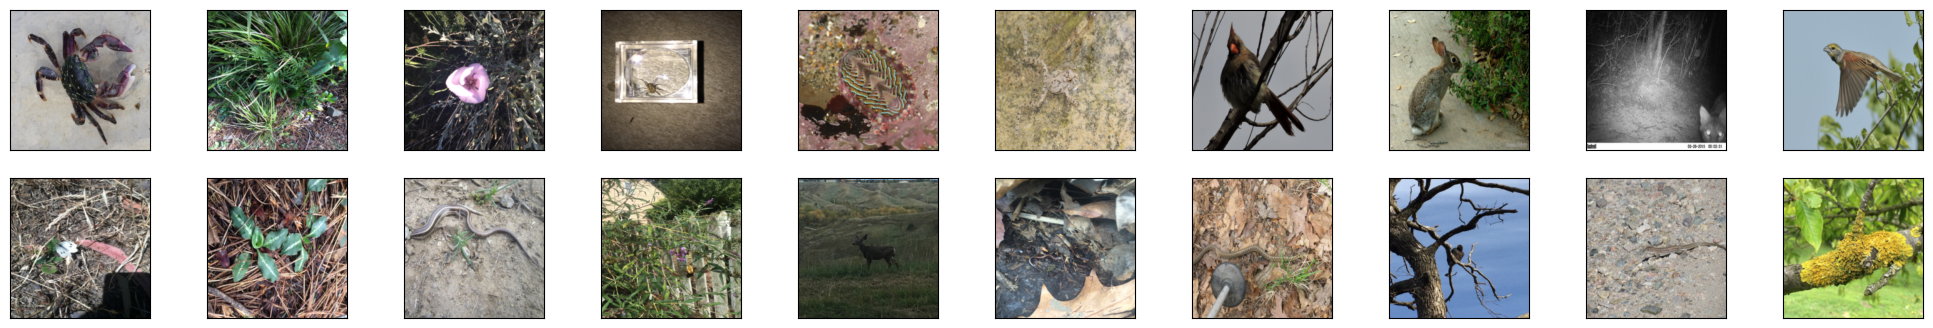

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert from Tensor to image

# Display a batch of images
dataiter = iter(train_loader_un)
images, labels = next(dataiter)
images = images.numpy()  # Convert images to numpy for display

fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20 // 2, i + 1, xticks=[], yticks=[])
    imshow(images[i])

## **Question-1**

In [21]:
##Formula to calculate output size: [(W−K+2P)/S]+1
def out_dimension(input,filter,stride,padding):
  out_dim=(input-filter+2*padding)//stride + 1
  return out_dim

In [22]:
class CNN_model(nn.Module):
  def __init__(self, no_of_filters, filters_size, act_func, neurons_dense_layer, input=224,   dropout=0.1, batch_norm=False):

        if act_func=="relu":
          act_func=nn.functional.relu
        elif act_func=='elu':
          act_func=nn.functional.elu
        elif act_func=='leaky_relu':
          act_func=nn.functional.leaky_relu



        super(CNN_model,self).__init__()
        self.batch_norm=batch_norm
        self.act_func=act_func
        self.neurons_dense_layer=neurons_dense_layer



        self.conv1 = nn.Conv2d(3, no_of_filters[0], filters_size[0], stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(no_of_filters[0])
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        width_conv=out_dimension(224,filters_size[0],1,1)
        width_mp=out_dimension(width_conv,2,2,0)

        for i in range(1,5):
          setattr(self, f"conv{i+1}", nn.Conv2d(no_of_filters[i-1], no_of_filters[i], filters_size[i], stride=1, padding=1))
          setattr(self, f"bn{i+1}", nn.BatchNorm2d(no_of_filters[i]))
          setattr(self, f"maxpool{i+1}", nn.MaxPool2d(kernel_size=2))
          width_conv=out_dimension(width_mp,filters_size[i],1,1)
          width_mp=out_dimension(width_conv,2,2,0)

        width_out=width_mp*width_mp*no_of_filters[-1]
        self.width_out=width_out

        self.dropout=nn.Dropout(dropout)
        self.Flatten=nn.Flatten(start_dim=1,end_dim=-1)
        self.dense_layer = nn.Linear(width_out, neurons_dense_layer)
        self.output_layer = nn.Linear(neurons_dense_layer, 10)

        print(width_out)


  def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm==True:
          x = self.bn1(x)
        x = self.act_func(x)
        x = self.maxpool1(x)

        for i in range(1,4):
          x = getattr(self, f"conv{i+1}")(x)
          if self.batch_norm:
              x = getattr(self, f"bn{i+1}")(x)
          x = self.act_func(x)
          x = getattr(self, f"maxpool{i+1}")(x)
          x = self.dropout(x)


        x = self.conv5(x)
        if self.batch_norm==True:
          x = self.bn5(x)
        x = self.act_func(x)
        x = self.maxpool5(x)

        x = x.view(-1,self.width_out)
        x = self.dense_layer(x)
        x = self.act_func(x)
        x = self.dropout(x)

        x = self.output_layer(x)
        return x

In [23]:
no_of_filters = [6,6,6,16,16]
filters_size = [3,3,3,3,3]
act_func = 'relu'
neurons_dense_layer = 120

print(torch.cuda.is_available())
CNN_model(no_of_filters, filters_size, act_func, neurons_dense_layer)

True
784


CNN_model(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [ ]:
My_model = CNN_model(no_of_filters, filters_size, act_func, neurons_dense_layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(My_model.parameters(), lr=0.001)

# Train the model (customize this part based on your training loop)
num_epochs = 3
for epoch in tqdm(range(num_epochs)):
    for batch in train_loader_un:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = My_model(inputs)
        print(labels.shape, inputs.shape, outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"epoch{epoch} - Loss: {loss.item():.4f}")

## **Question-2**

In [24]:
def train():

    config_defaults = {
      'batch_norm': False,
      'no_of_filters': [32,32,64,64,128],
      'dropout': 0.2,
      'data_augmentation': True,
      'num_epochs' : 10,
      'batch_size': 64,
      'neurons_dense_layer': 64,
      'learning_rate': 0.001,
      'act_func': "relu",
      'optimizer': "Adam",
      'filters_size': [3,3,3,3,3]

    }
      # Initializing the wandb run
    wandb.init(config=config_defaults)
    config = wandb.config
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = CNN_model(config.no_of_filters,config.filters_size,act_func,config.neurons_dense_layer, config.dropout,config.batch_norm).to(device)
    # Data loading

    if config.data_augmentation:
        train_loader, test_loader, val_loader = aug_data()
    else:
        train_loader, test_loader, val_loader = unaug_data()

    name_run = str(config.batch_norm) + "_"  + str(config.dropout) +  "_" + str(config.neurons_dense_layer) + \
                "_" + str(config.data_augmentation) + "_" + str(config.num_epochs)

    wandb.run.name = name_run
    wandb_log = True

    optimizer = optim.Adam(model.parameters(),lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss().to(device)
    gpu_train = torch.cuda.is_available()

    for epoch in tqdm(range(config.num_epochs)):

        train_loss = 0.0
        val_loss = 0.0
        val_accuracy = 0.0
        total=0.0
        correct=0.0


        model.train()
        for batch in train_loader:
            inputs, labels = batch
            if gpu_train:
              inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*inputs.size(0)

        model.eval()
        for batch in val_loader:
            inputs, labels = batch
            if gpu_train:
              inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()*inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total

    train_loss = train_loss/len(train_loader.dataset)
    val_loss = val_loss/len(val_loader.dataset)
    val_accuracy = val_accuracy
    if(wandb_log==True):
       epoc=0

       log_dict = {"Train_loss": train_loss, "Validation_loss": val_loss, "Validation_Accuracy": val_accuracy}
       epoc=epoc+1
       print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.5f} \tValidation Accuracy: {:.4f}'.format(epoc,
        train_loss, val_loss,val_accuracy))
       wandb.log(log_dict)

    wandb.run.save()
    wandb.run.finish()
    return model

In [25]:
# Setting up the entity name and project name.
entity_name = "team_zulkar"
project_name = "CS6910_Assignment_2A"

In [26]:
def sweeper(entity_name, project_name):

    hyperparameters={

    'batch_norm': {
        'values':[True, False]
    },
    'no_of_filters':{
        'values': [[32,32,32,32,32],[128,64,64,32,32],[64,64,64,64,64]]

    },

    'dropout':{
        'values':[0.0, 0.5, 0.6, 0.4]
    },

    'data_augmentation':{
        'values':[True, False]
    },

    'num_epochs': {
        'values':[10, 15, 20]
    },

    'batch_size': {
        'values':[32, 64, 128]
    },

    'neurons_dense_layer': {
        'values':[32, 64, 128, 256]
    },

    'learning_rate': {
        'values':[0.001, 0.0001]
    },

    'activation': {
            'values': ['relu','elu','leaky_relu']
    },

    'filters_size': {
        'values': [[3,3,5,7,7], [5,5,5,5,5], [3,3,3,3,3]]
    }

    }

    # Using bayes method for hyperparameter sweeps to curb the unnecessary configurations
    sweep_config = {
      'method' : 'bayes',
      'metric' :{
          'name': 'val_acc',
          'goal': 'maximize'
      },
      'parameters': hyperparameters
    }

    sweep_id = wandb.sweep(sweep_config, entity=entity_name, project=project_name)
    wandb.agent(sweep_id, train)

In [ ]:
sweeper(entity_name, project_name)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: o30gjjhu
Sweep URL: https://wandb.ai/team_zulkar/CS6910_Assignment_2A/sweeps/o30gjjhu


wandb: Agent Starting Run: 9zt40umd with config:
wandb: 	activation: elu
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dropout: 0.4
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 256
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 10
wandb: Currently logged in as: ph23m012 (team_zulkar). Use `wandb login --relogin` to force relogin


800


100%|██████████| 10/10 [11:39<00:00, 69.97s/it]
wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1 	Training Loss: 2.3027 	Validation Loss: 2.30378 	Validation Accuracy: 9.1500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.3027
Validation_Accuracy,9.15
Validation_loss,2.30378


wandb: Agent Starting Run: a8hsd1rd with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 128
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 15


800


100%|██████████| 15/15 [20:10<00:00, 80.73s/it]


Epoch: 1 	Training Loss: 1.8448 	Validation Loss: 1.92146 	Validation Accuracy: 31.0000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.84478
Validation_Accuracy,31.0
Validation_loss,1.92146


wandb: Agent Starting Run: 4c9j2isr with config:
wandb: 	activation: leaky_relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0.4
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 32
wandb: 	no_of_filters: [64, 64, 64, 64, 64]
wandb: 	num_epochs: 20


1600


100%|██████████| 20/20 [26:33<00:00, 79.67s/it]


Epoch: 1 	Training Loss: 2.3032 	Validation Loss: 2.30433 	Validation Accuracy: 9.3000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30321
Validation_Accuracy,9.3
Validation_loss,2.30433


wandb: Agent Starting Run: x4unrzvd with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0.6
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 256
wandb: 	no_of_filters: [64, 64, 64, 64, 64]
wandb: 	num_epochs: 20


3136


 45%|████▌     | 9/20 [11:38<14:11, 77.38s/it]

In [17]:
sweeper(entity_name, project_name)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 9sw61vmk
Sweep URL: https://wandb.ai/team_zulkar/CS6910_Assignment_2A/sweeps/9sw61vmk


wandb: Agent Starting Run: d52av0u8 with config:
wandb: 	activation: leaky_relu
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dropout: 0
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 64
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 20
wandb: Currently logged in as: ph23m012 (team_zulkar). Use `wandb login --relogin` to force relogin


800


100%|██████████| 20/20 [26:30<00:00, 79.55s/it]
wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch: 1 	Training Loss: 1.9237 	Validation Loss: 1.97757 	Validation Accuracy: 29.6500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.92369
Validation_Accuracy,29.65
Validation_loss,1.97757


wandb: Agent Starting Run: ekurpckc with config:
wandb: 	activation: elu
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dropout: 0.4
wandb: 	filters_size: [3, 3, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 128
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 15


288


100%|██████████| 15/15 [19:00<00:00, 76.02s/it]


Epoch: 1 	Training Loss: 1.9106 	Validation Loss: 1.96149 	Validation Accuracy: 31.3000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.91059
Validation_Accuracy,31.3
Validation_loss,1.96149


wandb: Agent Starting Run: p7n60av4 with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0.6
wandb: 	filters_size: [3, 3, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 256
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 20


288


100%|██████████| 20/20 [24:20<00:00, 73.00s/it]


Epoch: 1 	Training Loss: 1.8399 	Validation Loss: 1.91548 	Validation Accuracy: 32.3500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.83992
Validation_Accuracy,32.35
Validation_loss,1.91548


wandb: Agent Starting Run: s74ovryu with config:
wandb: 	activation: leaky_relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0.4
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 64
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 15


1568


100%|██████████| 15/15 [18:58<00:00, 75.92s/it]


Epoch: 1 	Training Loss: 2.3027 	Validation Loss: 2.30388 	Validation Accuracy: 9.1000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30267
Validation_Accuracy,9.1
Validation_loss,2.30388


wandb: Agent Starting Run: zrf8wsso with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dropout: 0
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 32
wandb: 	no_of_filters: [64, 64, 64, 64, 64]
wandb: 	num_epochs: 10


3136


100%|██████████| 10/10 [10:14<00:00, 61.45s/it]


Epoch: 1 	Training Loss: 1.8582 	Validation Loss: 1.97949 	Validation Accuracy: 30.7500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.85815
Validation_Accuracy,30.75
Validation_loss,1.97949


wandb: Agent Starting Run: xdgpkp8x with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dropout: 0.6
wandb: 	filters_size: [3, 3, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 256
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 15


288


100%|██████████| 15/15 [16:13<00:00, 64.88s/it]


Epoch: 1 	Training Loss: 1.6179 	Validation Loss: 1.88436 	Validation Accuracy: 34.7000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.61785
Validation_Accuracy,34.7
Validation_loss,1.88436


wandb: Agent Starting Run: ga71jtn1 with config:
wandb: 	activation: leaky_relu
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dropout: 0
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 32
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 10


1568


100%|██████████| 10/10 [10:42<00:00, 64.23s/it]


Epoch: 1 	Training Loss: 2.3047 	Validation Loss: 2.30453 	Validation Accuracy: 9.6500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30473
Validation_Accuracy,9.65
Validation_loss,2.30453


wandb: Agent Starting Run: oy8lf0j5 with config:
wandb: 	activation: elu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: False
wandb: 	dropout: 0.6
wandb: 	filters_size: [3, 3, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 128
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 20


288


100%|██████████| 20/20 [21:13<00:00, 63.67s/it]


Epoch: 1 	Training Loss: 0.9958 	Validation Loss: 3.34879 	Validation Accuracy: 25.1000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,0.99584
Validation_Accuracy,25.1
Validation_loss,3.34879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q92imze1 with config:
wandb: 	activation: leaky_relu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 256
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 10


800


100%|██████████| 10/10 [12:16<00:00, 73.62s/it]


Epoch: 1 	Training Loss: 1.9507 	Validation Loss: 1.95475 	Validation Accuracy: 31.0500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.95067
Validation_Accuracy,31.05
Validation_loss,1.95475


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kspahvsl with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dropout: 0.4
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 128
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 10


800


100%|██████████| 10/10 [12:19<00:00, 73.94s/it]


Epoch: 1 	Training Loss: 1.9533 	Validation Loss: 1.99368 	Validation Accuracy: 29.3000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.95325
Validation_Accuracy,29.3
Validation_loss,1.99368


wandb: Agent Starting Run: 0lkb1e6l with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dropout: 0.5
wandb: 	filters_size: [3, 3, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 32
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 10


288


100%|██████████| 10/10 [12:11<00:00, 73.17s/it]


Epoch: 1 	Training Loss: 2.3027 	Validation Loss: 2.30368 	Validation Accuracy: 8.7500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30272
Validation_Accuracy,8.75
Validation_loss,2.30368


wandb: Agent Starting Run: w2ay44ec with config:
wandb: 	activation: leaky_relu
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dropout: 0.4
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 64
wandb: 	no_of_filters: [64, 64, 64, 64, 64]
wandb: 	num_epochs: 10


3136


100%|██████████| 10/10 [12:28<00:00, 74.83s/it]


Epoch: 1 	Training Loss: 2.3027 	Validation Loss: 2.30328 	Validation Accuracy: 8.9500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.3027
Validation_Accuracy,8.95
Validation_loss,2.30328


wandb: Agent Starting Run: a78hudhw with config:
wandb: 	activation: elu
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dropout: 0
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 256
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 10


1568


100%|██████████| 10/10 [10:19<00:00, 61.95s/it]


Epoch: 1 	Training Loss: 1.3605 	Validation Loss: 2.11217 	Validation Accuracy: 33.5000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.36045
Validation_Accuracy,33.5
Validation_loss,2.11217


wandb: Agent Starting Run: 4w1wtyll with config:
wandb: 	activation: elu
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dropout: 0.4
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 128
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 15


800


100%|██████████| 15/15 [16:31<00:00, 66.09s/it]


Epoch: 1 	Training Loss: 2.3029 	Validation Loss: 2.30348 	Validation Accuracy: 10.3000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30293
Validation_Accuracy,10.3
Validation_loss,2.30348


wandb: Agent Starting Run: 9k422ipj with config:
wandb: 	activation: elu
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dropout: 0
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 64
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 20


800


100%|██████████| 20/20 [20:51<00:00, 62.55s/it]


Epoch: 1 	Training Loss: 2.3028 	Validation Loss: 2.30431 	Validation Accuracy: 9.1000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30284
Validation_Accuracy,9.1
Validation_loss,2.30431


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l9x32w3j with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0.5
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 256
wandb: 	no_of_filters: [64, 64, 64, 64, 64]
wandb: 	num_epochs: 10


3136


100%|██████████| 10/10 [13:21<00:00, 80.14s/it]


Epoch: 1 	Training Loss: 2.3027 	Validation Loss: 2.30333 	Validation Accuracy: 9.6500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30273
Validation_Accuracy,9.65
Validation_loss,2.30333


wandb: Agent Starting Run: h1igyupy with config:
wandb: 	activation: elu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0.6
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 64
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 15


1568


100%|██████████| 15/15 [20:08<00:00, 80.58s/it]


Epoch: 1 	Training Loss: 2.3027 	Validation Loss: 2.30321 	Validation Accuracy: 9.1000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30273
Validation_Accuracy,9.1
Validation_loss,2.30321


wandb: Agent Starting Run: qamvrt8o with config:
wandb: 	activation: leaky_relu
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dropout: 0.6
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 32
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 20


1568


100%|██████████| 20/20 [22:41<00:00, 68.06s/it]


Epoch: 1 	Training Loss: 2.3028 	Validation Loss: 2.30311 	Validation Accuracy: 9.0000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30275
Validation_Accuracy,9.0
Validation_loss,2.30311


wandb: Agent Starting Run: f1mf8ihz with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dropout: 0.5
wandb: 	filters_size: [3, 3, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 128
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 15


288


100%|██████████| 15/15 [16:12<00:00, 64.86s/it]


Epoch: 1 	Training Loss: 2.3028 	Validation Loss: 2.30329 	Validation Accuracy: 9.0000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30276
Validation_Accuracy,9.0
Validation_loss,2.30329


wandb: Agent Starting Run: fi5wub54 with config:
wandb: 	activation: elu
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dropout: 0
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 128
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 20


800


100%|██████████| 20/20 [27:32<00:00, 82.64s/it]


Epoch: 1 	Training Loss: 1.8960 	Validation Loss: 1.96606 	Validation Accuracy: 29.7000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.89599
Validation_Accuracy,29.7
Validation_loss,1.96606


wandb: Agent Starting Run: 2qapl657 with config:
wandb: 	activation: leaky_relu
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dropout: 0.6
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 32
wandb: 	no_of_filters: [64, 64, 64, 64, 64]
wandb: 	num_epochs: 10


1600


100%|██████████| 10/10 [10:50<00:00, 65.07s/it]


Epoch: 1 	Training Loss: 2.3052 	Validation Loss: 2.30552 	Validation Accuracy: 10.9000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30519
Validation_Accuracy,10.9
Validation_loss,2.30552


wandb: Agent Starting Run: arzhbgaf with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dropout: 0.4
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 32
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 10


1568


100%|██████████| 10/10 [10:39<00:00, 63.93s/it]


Epoch: 1 	Training Loss: 1.9481 	Validation Loss: 1.97767 	Validation Accuracy: 29.6500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.94807
Validation_Accuracy,29.65
Validation_loss,1.97767


wandb: Agent Starting Run: ty2hj6qv with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dropout: 0.4
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 256
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 15


1568


100%|██████████| 15/15 [16:04<00:00, 64.33s/it]


Epoch: 1 	Training Loss: 2.3027 	Validation Loss: 2.30400 	Validation Accuracy: 9.6000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.3027
Validation_Accuracy,9.6
Validation_loss,2.304


wandb: Agent Starting Run: i57zvrtm with config:
wandb: 	activation: elu
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dropout: 0.5
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 64
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 10


1568


100%|██████████| 10/10 [12:32<00:00, 75.21s/it]


Epoch: 1 	Training Loss: 2.3038 	Validation Loss: 2.30400 	Validation Accuracy: 9.8500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30378
Validation_Accuracy,9.85
Validation_loss,2.304


wandb: Agent Starting Run: cx0l51q8 with config:
wandb: 	activation: elu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 32
wandb: 	no_of_filters: [64, 64, 64, 64, 64]
wandb: 	num_epochs: 20


3136


100%|██████████| 20/20 [25:20<00:00, 76.02s/it]


Epoch: 1 	Training Loss: 1.8688 	Validation Loss: 1.88746 	Validation Accuracy: 34.1500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.86879
Validation_Accuracy,34.15
Validation_loss,1.88746


wandb: Agent Starting Run: x6cytez0 with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0.4
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 256
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 10


800


100%|██████████| 10/10 [12:36<00:00, 75.63s/it]


Epoch: 1 	Training Loss: 2.3027 	Validation Loss: 2.30439 	Validation Accuracy: 9.0500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30267
Validation_Accuracy,9.05
Validation_loss,2.30439


wandb: Agent Starting Run: eoeyqc2c with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dropout: 0.4
wandb: 	filters_size: [3, 3, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 32
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 15


288


100%|██████████| 15/15 [15:37<00:00, 62.47s/it]


Epoch: 1 	Training Loss: 1.7116 	Validation Loss: 1.89940 	Validation Accuracy: 31.6000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.71162
Validation_Accuracy,31.6
Validation_loss,1.8994


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zz11slmz with config:
wandb: 	activation: leaky_relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0.5
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 64
wandb: 	no_of_filters: [64, 64, 64, 64, 64]
wandb: 	num_epochs: 10


1600


100%|██████████| 10/10 [12:54<00:00, 77.47s/it]


Epoch: 1 	Training Loss: 2.3027 	Validation Loss: 2.30386 	Validation Accuracy: 9.0500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30266
Validation_Accuracy,9.05
Validation_loss,2.30386


wandb: Agent Starting Run: 29oy517g with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0.5
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 64
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 10


800


100%|██████████| 10/10 [12:36<00:00, 75.67s/it]


Epoch: 1 	Training Loss: 1.9719 	Validation Loss: 2.01863 	Validation Accuracy: 28.0000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,1.97189
Validation_Accuracy,28.0
Validation_loss,2.01863


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iis4hu9x with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0.4
wandb: 	filters_size: [5, 5, 5, 5, 5]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 32
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 10


800


100%|██████████| 10/10 [12:20<00:00, 74.03s/it]


Epoch: 1 	Training Loss: 2.3051 	Validation Loss: 2.30591 	Validation Accuracy: 10.2000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30511
Validation_Accuracy,10.2
Validation_loss,2.30591


wandb: Agent Starting Run: ya5wg1z1 with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dropout: 0.5
wandb: 	filters_size: [3, 3, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	neurons_dense_layer: 256
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 10


288


100%|██████████| 10/10 [12:52<00:00, 77.24s/it]


Epoch: 1 	Training Loss: 2.3028 	Validation Loss: 2.30373 	Validation Accuracy: 9.0500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.30275
Validation_Accuracy,9.05
Validation_loss,2.30373


wandb: Agent Starting Run: 1pq739li with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dropout: 0.6
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 128
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 15


1568


100%|██████████| 15/15 [15:42<00:00, 62.85s/it]


Epoch: 1 	Training Loss: 0.3835 	Validation Loss: 5.47140 	Validation Accuracy: 26.9500


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,0.38346
Validation_Accuracy,26.95
Validation_loss,5.4714


wandb: Agent Starting Run: omjs63ba with config:
wandb: 	activation: leaky_relu
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dropout: 0.4
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 64
wandb: 	no_of_filters: [128, 64, 64, 32, 32]
wandb: 	num_epochs: 20


1568


100%|██████████| 20/20 [25:05<00:00, 75.29s/it]


Epoch: 1 	Training Loss: 2.3027 	Validation Loss: 2.30426 	Validation Accuracy: 8.5000


Train_loss,▁
Validation_Accuracy,▁
Validation_loss,▁
Train_loss,2.3027
Validation_Accuracy,8.5
Validation_loss,2.30426


wandb: Agent Starting Run: so5exq7j with config:
wandb: 	activation: leaky_relu
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dropout: 0.4
wandb: 	filters_size: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	neurons_dense_layer: 128
wandb: 	no_of_filters: [32, 32, 32, 32, 32]
wandb: 	num_epochs: 15


1568


 13%|█▎        | 2/15 [02:01<13:12, 60.98s/it]wandb: Ctrl + C detected. Stopping sweep.


## **Question-3**

1. Using high number of neurons in dense layer is better.
2. Using more no. of filters in initial layers is better.
3. Data augmentation is many times good.
4. Using small filters in initial layers is better.

## **Question-4**

**From above hypermeters tuning i found best hypermeters with validation accuracy of 35.1%,so i have run the model with test data on these best hypermeters below**

In [27]:
# Function to run the model on the best hyperparameters
def test_data_training(entity_name, project_name):

    best_hyperparameters = {
      'batch_norm': False,
      'no_of_filters': [64, 64, 64, 64, 64],
      'dropout': 0.6,
      'data_augmentation': True,
      'num_epochs' : 20,
      'batch_size': 32,
      'neurons_dense_layer': 256,
      'learning_rate': 0.001,
      'act_func': "relu",
      'optimizer': "Adam",
      'filters_size': [3, 3, 3, 3, 3]
    }

     # Initializing the wandb run
    wandb.init(config=best_hyperparameters)
    config = wandb.config
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = CNN_model(config.no_of_filters,config.filters_size,act_func,config.neurons_dense_layer, config.dropout,config.batch_norm).to(device)
    # Data loading

    if config.data_augmentation:
        train_loader, test_loader, val_loader = aug_data()
    else:
        train_loader, test_loader, val_loader = unaug_data()

    name_run = "Test Run"

    wandb.run.name = name_run
    wandb_log = True

    optimizer = optim.Adam(model.parameters(),lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss().to(device)
    gpu_train = torch.cuda.is_available()

    for epoch in tqdm(range(config.num_epochs)):

        test_loss = 0.0
        test_accuracy = 0.0
        total = 0
        correct = 0

        model.train()
        for batch in test_loader:
            inputs, labels = batch
            if gpu_train:
              inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            test_loss += loss.item()*inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {test_accuracy:.2f}%")

    test_loss = test_loss/len(test_loader.dataset)
    test_accuracy = test_accuracy

    if(wandb_log==True):
       epoc=0
       log_dict = {"Test_loss": test_loss, "Test_Accuracy": test_accuracy}
       epoc=epoc+1
       print('Epoch: {} \tTest Loss: {:.4f} \tTest Accuracy: {:.4f}'.format(epoc,
        test_loss,test_accuracy))
       wandb.log(log_dict)

    wandb.run.save()
    wandb.run.finish()
    return model

In [28]:
model = test_data_training(entity_name, project_name)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


3136


  5%|▌         | 1/20 [00:17<05:33, 17.54s/it]

Test Accuracy: 11.30%


 10%|█         | 2/20 [00:30<04:25, 14.73s/it]

Test Accuracy: 17.95%


 15%|█▌        | 3/20 [00:42<03:54, 13.78s/it]

Test Accuracy: 22.80%


 20%|██        | 4/20 [00:55<03:32, 13.27s/it]

Test Accuracy: 24.20%


 25%|██▌       | 5/20 [01:08<03:16, 13.09s/it]

Test Accuracy: 27.10%


 30%|███       | 6/20 [01:20<03:00, 12.89s/it]

Test Accuracy: 29.50%


 35%|███▌      | 7/20 [01:33<02:48, 12.97s/it]

Test Accuracy: 30.50%


 40%|████      | 8/20 [01:46<02:34, 12.85s/it]

Test Accuracy: 34.15%


 45%|████▌     | 9/20 [01:59<02:21, 12.85s/it]

Test Accuracy: 40.80%


 50%|█████     | 10/20 [02:11<02:07, 12.76s/it]

Test Accuracy: 46.60%


 55%|█████▌    | 11/20 [02:24<01:54, 12.71s/it]

Test Accuracy: 54.30%


 60%|██████    | 12/20 [02:37<01:42, 12.77s/it]

Test Accuracy: 67.65%


 65%|██████▌   | 13/20 [02:49<01:28, 12.62s/it]

Test Accuracy: 77.20%


 70%|███████   | 14/20 [03:01<01:15, 12.53s/it]

Test Accuracy: 86.50%


 75%|███████▌  | 15/20 [03:14<01:02, 12.55s/it]

Test Accuracy: 87.75%


 80%|████████  | 16/20 [03:26<00:49, 12.47s/it]

Test Accuracy: 90.10%


 85%|████████▌ | 17/20 [03:39<00:37, 12.66s/it]

Test Accuracy: 94.15%


 90%|█████████ | 18/20 [03:52<00:25, 12.53s/it]

Test Accuracy: 93.10%


 95%|█████████▌| 19/20 [04:04<00:12, 12.43s/it]

Test Accuracy: 95.95%


100%|██████████| 20/20 [04:17<00:00, 12.86s/it]
wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Test Accuracy: 95.50%
Epoch: 1 	Test Loss: 0.1445 	Test Accuracy: 95.5000


Test_Accuracy,▁
Test_loss,▁
Test_Accuracy,95.5
Test_loss,0.14448


**So, with these best hyperparameters the test accuracy comes out to be 95.5%**

I dont know why the accuracy comes this much good on test data, maybe because before running this best hypermeters sweep on this untouched test data, a previous sweep of hyperparameters tuning which was aborted and not completed, continued on this test data.